In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

In [28]:
!pip install Sequential

  Preparing metadata (setup.py) ... done
  Created wheel for Sequential: filename=sequential-1.0.0-py3-none-any.whl size=2880 sha256=9ff170beeda7698bd78174b0a8d644ba749da4a2f0c214137841a7525ef4fa97
  Stored in directory: /home/tahmida/.cache/pip/wheels/e9/75/a4/285f10d64daf30955cb07d31a37f9f83fcd5779c6773e18f48
Successfully built Sequential


In [5]:
train_df = pd.read_csv("/home/tahmida/Desktop/dataset/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("/home/tahmida/Desktop/dataset/sign_mnist_test/sign_mnist_test.csv")

In [9]:
!pip install seaborn

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)


In [11]:
!pip install keras

  Using cached keras-2.7.0-py2.py3-none-any.whl (1.3 MB)


!pip install tensorflow

# Loading the ASL dataset

test = pd.read_csv("/home/tahmida/Desktop/dataset/sign_mnist_train/sign_mnist_train.csv")
y = test['label']

In [7]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


# Data Visualization and Preprocessing

/home/tahmida/fastapi/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

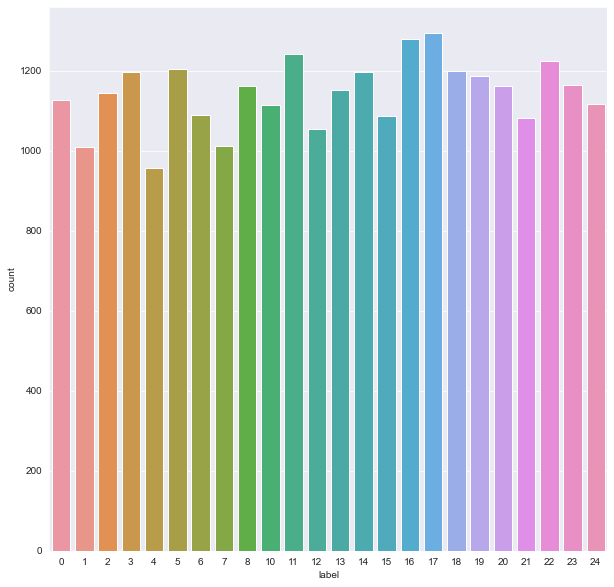

In [9]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(train_df['label'])


In [10]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [11]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [12]:
x_train = train_df.values
x_test = test_df.values

In [13]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [14]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

Preview of first 10 images

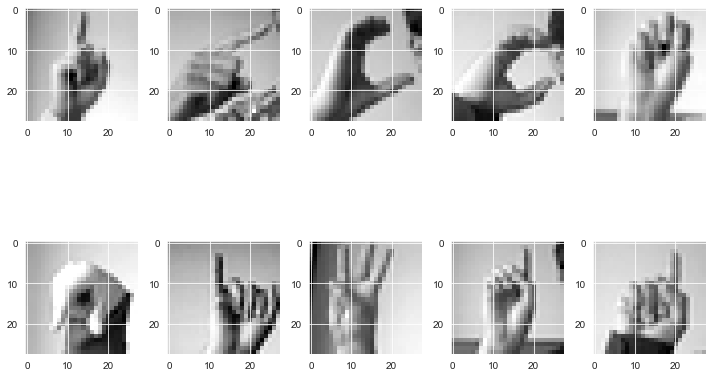

In [15]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()    


Data Augmentation

In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.


In [16]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, i choosed to :

Randomly rotate some training images by 10 degrees Randomly Zoom by 10% some training images Randomly shift images horizontally by 10% of the width Randomly shift images vertically by 10% of the height I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify.

Once our model is ready, we fit the training dataset .


# CONVOLUTIONAL NEURAL NETWORKS TO THE RESCUE

A Convolutional Neural Network is a special type of an Artificial Intelligence implementation which uses a special mathematical matrix manipulation called the convolution operation to process data from the images.

    A convolution does this by multiplying two matrices and yielding a third, smaller matrix.
    The Network takes an input image, and uses a filter (or kernel) to create a feature map describing the image.
    In the convolution operation, we take a filter (usually 2x2 or 3x3 matrix ) and slide it over the image matrix. The coresponding numbers in both matrices are multiplied and and added to yield a single number describing that input space. This process is repeated all over the image.This working can be seen in the following figure

# Training The Model

In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [49]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 28, 28, 75)        750       
                                                                 
 batch_normalization_15 (Bat  (None, 28, 28, 75)       300       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 75)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 50)        33800     
                                                                 
 dropout_10 (Dropout)        (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_16 (Bat  (None, 14, 14, 50)      

In [48]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/20
215/215 [==============================] - 26s 120ms/step - loss: 0.5460 - accuracy: 0.8192 - val_loss: 2.6936 - val_accuracy: 0.2144 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 25s 118ms/step - loss: 0.1673 - accuracy: 0.9459 - val_loss: 1.4992 - val_accuracy: 0.5763 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 26s 120ms/step - loss: 0.0904 - accuracy: 0.9711 - val_loss: 0.0449 - val_accuracy: 0.9908 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 25s 118ms/step - loss: 0.0593 - accuracy: 0.9811 - val_loss: 0.0293 - val_accuracy: 0.9902 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - ETA: 0s - loss: 0.0406 - accuracy: 0.9874
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
215/215 [==============================] - 27s 127ms/step - loss: 0.0406 - accuracy: 0.9874 - val_loss: 0.0843 - val_accuracy: 0.9776 - lr: 0.0010
Epoch 6/20
215/215 [=========================

In [20]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 [==============================] - 2s 8ms/step - loss: 0.0021 - accuracy: 0.9994
Accuracy of the model is -  99.94422793388367 %


# Analysis after Model Training


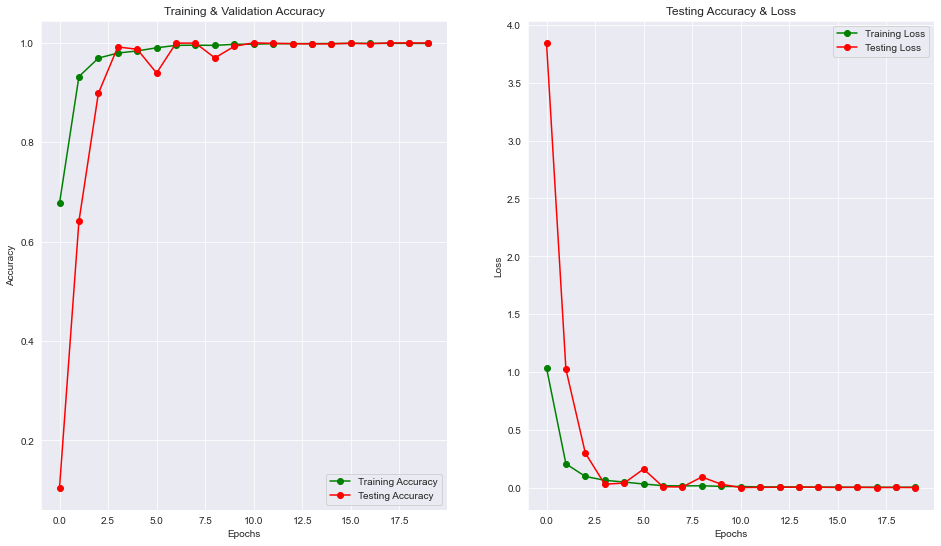

In [21]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [83]:
y_predict = np.argmax(model.predict(x_test), axis=-1)

predictions[:5]   

array([[0.04091799, 0.0403145 , 0.04202123, 0.04169688, 0.04262618,
        0.04057848, 0.04137373, 0.04136313, 0.04159526, 0.04018748,
        0.0415679 , 0.04215823, 0.04239628, 0.04070146, 0.04402333,
        0.04103786, 0.04241824, 0.04209754, 0.04242364, 0.04191988,
        0.04069719, 0.04099752, 0.04343499, 0.04145108],
       [0.04076233, 0.04031939, 0.04236982, 0.04148075, 0.04263055,
        0.04028156, 0.04150962, 0.04101247, 0.04180853, 0.04003328,
        0.0413659 , 0.0426363 , 0.0429271 , 0.04037507, 0.04408685,
        0.04063379, 0.04282486, 0.04191622, 0.04221702, 0.04164833,
        0.04093831, 0.04103237, 0.04320868, 0.04198088],
       [0.04047789, 0.04037319, 0.04206691, 0.04147539, 0.04312807,
        0.04050838, 0.04173282, 0.0411946 , 0.04183938, 0.04006791,
        0.04150677, 0.04266084, 0.04286152, 0.04037387, 0.04427748,
        0.04050635, 0.04300651, 0.04177278, 0.04246964, 0.04189304,
        0.04058852, 0.04067086, 0.04304115, 0.04150613],
       [0.040

In [98]:
plt.figure(figsize = (15,15))

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>